# Separating Mouse and Human Antibody Sequences using Protein Encoding and Machine Learning Classifiers

### Questions:

- How may we create a machine learning classifier that can tell apart two groups of proteins?

- How may we improve upon the performance of a machine learning classifier that does not perform so well?

- How may we check for overfitting in a trained machine learning classifier?

- How may we pick the most relevant data points that are related to the class of a sample?

- Can we also train a deep learning predictor to tell proteins apart?

### Objectives:
    
- Understand how protein sequences can become readable to machine learning predictors

- Practise machine learning optimisation techniques including GridSearchCV and dimensionality reduction

- Check for overfitted data by testing with a totally naive dataset

- Pracitse prediction by applying a deep learning model to the problem and evaluating its performance


### Introduction 

If we want to generate a classifier that observes the differences between two groups of protein seequences, then we need to extract numerical information from our sequences. This is called encoding and can be done through a variety of ways inlcuding residue level encoding of each amino acid in your sequences with a 1x20 vector, representing the possibility of 20 amino acids at each residue. This is called One Hot Encoding, but often leads to a sparse dataset which is not suitable for machine learning tasks and each sequence must be spaced out so they are of equal length. Instead, in this example we use the physiochemical properties that may be calculated from the sequence as our numeric information (ElAbd et al., 2020). 

Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan et al., 2018).

In this exercise, we will use a sample of 1000 Human and 1000 Mouse paired antibodies taken from the Observed Antibody Space (Olsen et al., 2022) and develop a machine learning classifier to separate them. Firstly we will use Propythia (Sequeira et al., 2022) to generate our encodings from an input of Fasta formatted sequences. Secondly we will split those encodings into training and test datasets for a selection of machine learning classifiers and plot our results. Finally we will try to improve our performance through principal component analysis (PCA), which also helps to visualise our dataset.

### References

ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235. https://doi.org/10.1186/s12859-020-03546-x

Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102

Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant
human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5. https://doi.org/10.1038/s42003-017-0006-2


In [8]:
import xgboost as xgb
import sys
import pandas as pd
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor
from propythia.sequence import ReadSequence
from propythia.descriptors import Descriptor
from propythia.feature_selection import FeatureSelection
from propythia.linear_dim_reduction import FeatureDecomposition
from propythia.deep_ml import DeepML
from sklearn.metrics import matthews_corrcoef
from propythia.manifold import Manifold
from propythia.adjuv_functions.ml_deep.utils import divide_dataset, binarize_labels
from propythia.shallow_ml import ShallowML
from propythia.deep_ml import DeepML
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from pandas import read_csv
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from pandas import read_csv
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
import xgboost as xgb
from sklearn import metrics
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle


## Generating the Encoded Dataset

Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences. There are 4000 records in the fasta file representing 2000 paired antibodies (1000 human and 1000 mouse).

In [9]:
###Propythia Command to get encodings###
def get_descriptors(protein):
    # creating object to calculate descriptors
    # all except tripeptide and binaries representations, nlf and blosum encodings
    #test=protein.get_all(tricomp=False, bin_aa=False, bin_prop=False) 
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [10]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    print(len(VH_sequences),len(VL_sequences))
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VH_dataframe = VH_dataframe.append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VL_dataframe = VL_dataframe.append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


In [12]:
### Input Fasta and Run Dataset###
#input_fasta = '/Users/james/Documents/LIDO/Antibody_Materials/HumanMouseOAS_VH_VL_paired_data.faa'

#joined_dataframe_VH_VL = Get_dataset(input_fasta)

#Optionally save dataframe as a CSV to simply reload it in future
#joined_dataframe_VH_VL.to_csv('/Users/james/Documents/LIDO/Antibody_Materials/HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors')#
joined_dataframe_VH_VL = read_csv('/Users/james/Documents/LIDO/Antibody_Materials/HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)

### Do it yourself
- These encodings used with Propythia were selected to reduce the time taken to run. Retry the encoding step and experiment with the protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]) array.

- NB Propythia accepts numbers 0-40 however we avoid 1 and 2 as these produce outputs of differing length

Now we have our encodings, we need to prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing just that

In [13]:

#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 890)


Now that we have our datasets, we may not split them into training datasets for fitting our classifiers to and training datasets to verify their effectiveness as predictors. Usually 70/30 - 80/20 split is necessary.

In [14]:

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


## Separating our data with Machine Learning Classifiers
Here is our list of classifiers that we will loop through to see which is the best at clustering our dataset

In [15]:
n=2
RANDOM_SEED=42
classifiers = {
    'Guassian':GaussianMixture(n_components=n),
    'KMeans': KMeans(n_clusters=n) ,
    'KNeighbours': KNeighborsClassifier(2),
    'SVC':SVC(kernel="linear", C=0.025),
   'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}


### Do it yourself
- This is not an exhaustive list of classifiers. These were mostly picked to represent all of the different kinds of models. 
Here you will find a much larger list of classifiers. Try adding some to the classifiers dictionary and see how the results differ.
Additional models that are supported in scikit learn can be found here: https://scikit-learn.org/stable/supervised_learning.html

Now loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. I have chosen Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by taking into account false predictions, as well as true predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood. We then plot our results as a confusion matrix which demonstrates the predictive power of our classifiers. The Confusion matrix shows the raw number of records that have been assigned to each category in a 2x2 matrix and is given as such: 

|                  | Predicted Class = 0  | Predicted Class = 1 |
|------------------|----------------------|---------------------|
| Actual Class = 0 | True Negative        | False Positive      |
| Actual Class = 1 |  False Negative      | True Positive       |

Ideally we want the True Negative and True Positive field to be the most popular fields with only a few records in the false positive fields.

NOTE: Results may vary between each run due to the stochastic nature of the machine learning algorithms.

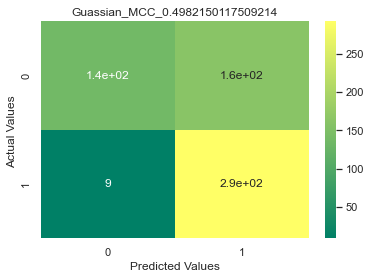

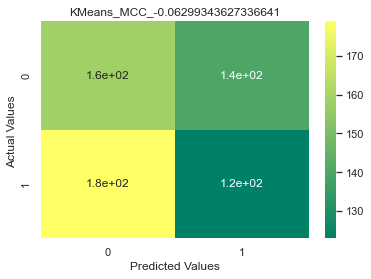

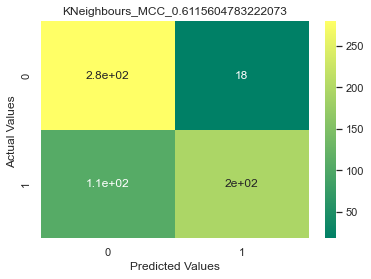

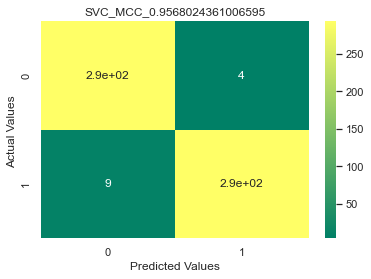

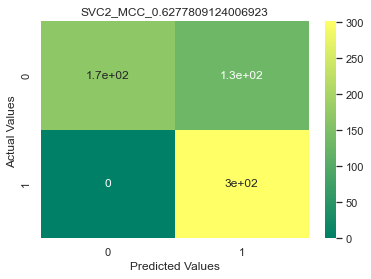

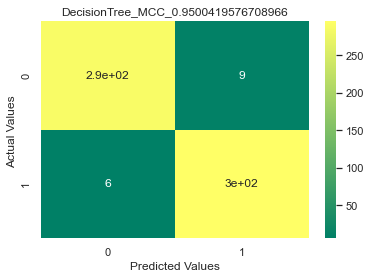

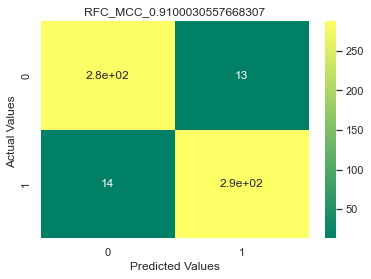

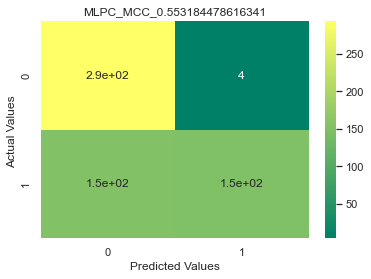

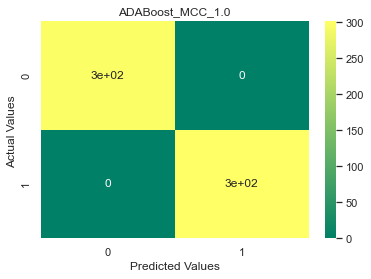

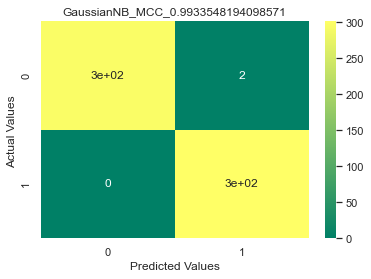

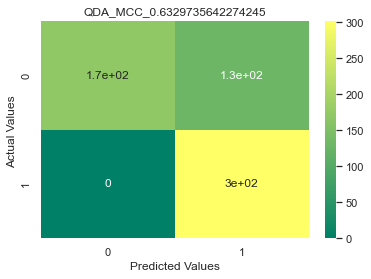

In [102]:
scores = []

for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring)     
    cf_matrix1 = confusion_matrix(y_test, y_predict1)
    ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
    title = str(str(i) + "_MCC_"+str(scoring))
    ax1.set_title(title);
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Actual Values ');
    plt.show()


We may now plot our MCC scores by classifier to see which performed best.

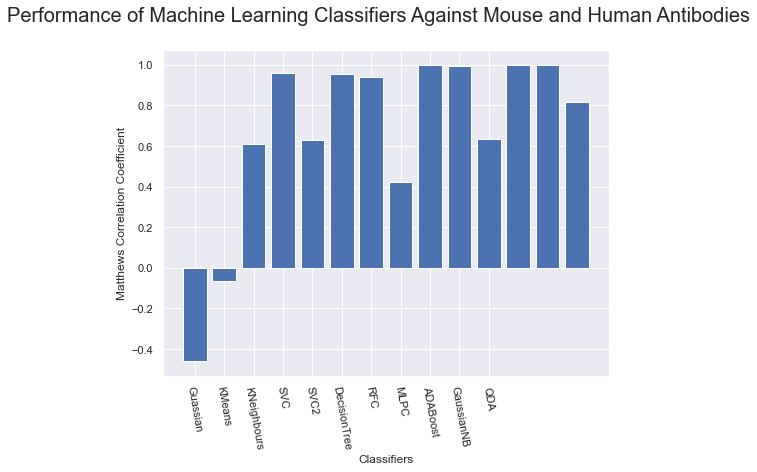

In [77]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

From the above chart, we can see that the best performing predictors are ADA_Boost, GaussinNB, DecisionTree and SVC are the best performing classifier, wheras both Gaussian and KMeans are the worst performing with negative MCC scores.


## Improving the Performance of Machine Learning Predictors

When a machine learning predictor is performing well, there is always the possibility of improving its performance through hyperparameterisation. This means editing its parameters until a maximum score and optimisation are reached. This is usually done through either GridSearchCV which does this using a reference grid and systematically compares each combination with every other, or RandomSearchCV, which is more stochastic and instead samples from ranges which may be applied to each parameter. Here we will apply the GridSearchCV on both the SVC2 and RandomForestClassifier predictor to try and increase its performance on our dataset.

It is important to know that not all classifiers have the capacity for GridSearchCV.

These processes will take a few minutes

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[1,10,100,1000],
              'gamma':[2,1,0.1,0.001],
              'kernel':['linear','rbf']
}

svc = SVC()
svc_grid_search = GridSearchCV(estimator = svc, param_grid=  param_grid,
                               refit = True, n_jobs = -1,verbose = 2)
svc_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [2, 1, 0.1, 0.001]},
             verbose=2)

In [21]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
rf_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

{'C': 10, 'gamma': 0.001}


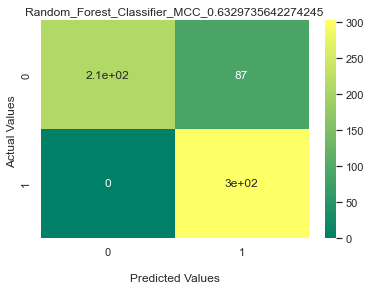

In [32]:
print(svc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = svc_grid_search.predict(X_test)
svc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_SVC2_MCC_"+str(svc_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

{'bootstrap': True, 'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


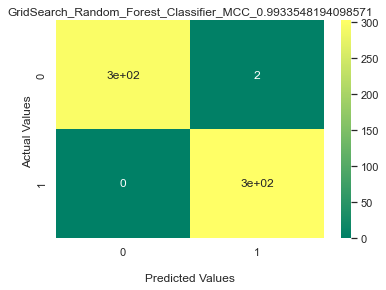

In [59]:
print(rf_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = rf_grid_search.predict(X_test)
rf_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_Random_Forest_Classifier_MCC_"+str(rf_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

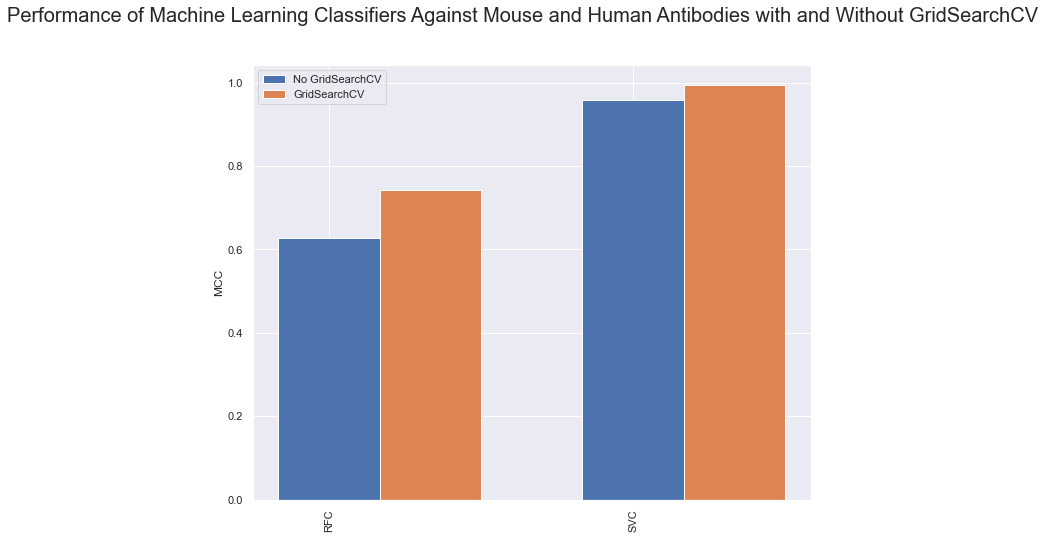

In [100]:
import numpy as np 
import matplotlib.pyplot as plt

classifiers2 = ["RFC","SVC"]
no_grid_scores = [scores[4],scores[6]]
grid_scores = [svc_grid_search_scoring, rf_grid_search_scoring] 
labels = classifiers2
aranged = np.arange(len(classifiers2)) 
width = 1/3

fig, ax = plt.subplots(figsize=(10,8))

bar1 = plt.bar(aranged, no_grid_scores, width,label = 'No GridSearchCV')
bar2 = plt.bar(aranged+width, grid_scores , width,label = 'GridSearchCV')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We can see that both classifiers have an improved performance, however we have not seen substantial performance in the 

## Do it yourself

- GridSearchCV is not the only kind of hyperparameter optimisation technique. RandomizedSearchCV is similar to GridSearchCV but instead of iterating over every combination of specified parameter, it randomly samples intervals for for a given number of iterations and notes which settings score the best. Documentation can be found here: https://scikit-learn.org/stable/supervised_learning.html

- Try optimising the Random Forest Classifier with RandomizedSearchCV instead and see how similar the best parameters are and how similar the MCC values are

## Feature Importance

A Random Forest Classifier has a feature importance instance, where the features that contribute most highly to the determination of the classifier may be examined and plotted. Using the best hyperparameters found by the GridSearchCV alogrithm, we may declare a new Random Forest and investigate which features are the most significant.

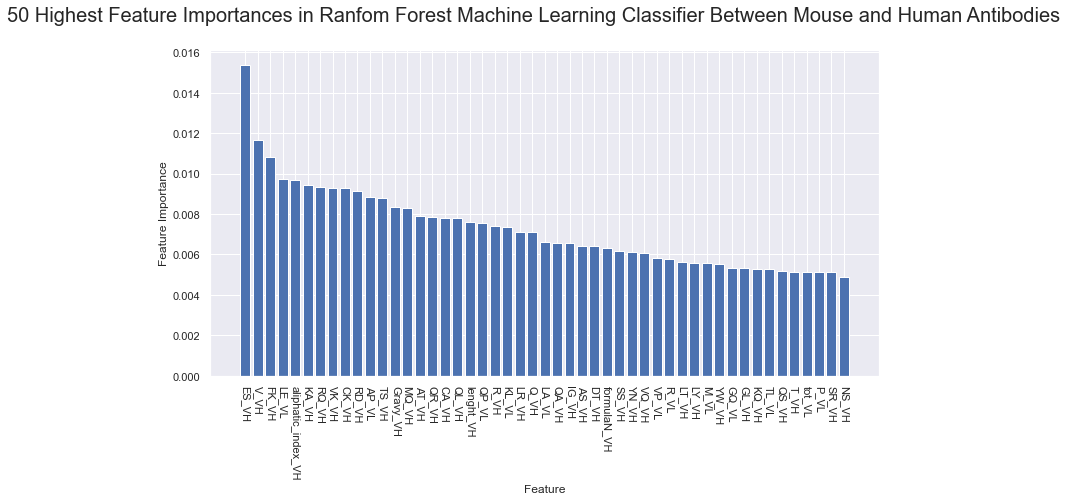

In [73]:
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
RF_Best_Params.fit(X_train, y_train)
importances  =  RF_Best_Params.feature_importances_
sorted_importances = sorted(importances, reverse=True)
feature_names = X_train.columns
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]
fig, ax = plt.subplots(figsize=(12,6))

plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[0:49], sorted_importances[0:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[0:49], rotation=-90);
plt.show()

## Testing our Classifiers on a Naive Dataset

We may also take a totally naive dataset that the model has not been exposed to. This is a measure to check for overfitting. If we see that there is poor performance on this naive "held back" dataset, then it could suggest overfitting to the training data. Using 20 Human and 20 mouse paired sequences from OAS which were not used to train our models, We can generate their encodings and pass them through the optimised model to test it.  In this case, we will use only the top performing models: ADABoost and GuassianNB.

In [58]:
naive_fasta = '/Users/james/Documents/LIDO/Antibody_Materials/Naive_dataset.faa.txt'
naive_dataset = Get_dataset(naive_fasta)
naive_labels1 = 20*[1]
naive_labels2 = 20*[0]
naive_labels = naive_labels1+naive_labels2
naive_y=naive_labels

40 40
VH_data (40, 445)
VL_data (40, 445)


We should select high performing classifiers to test this naive dataset. We select the ADABoost and our improved RFC predictors to try this.

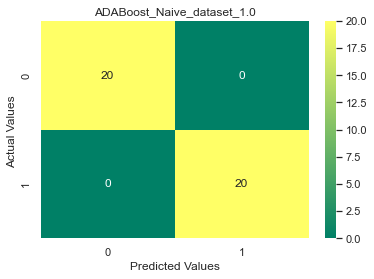

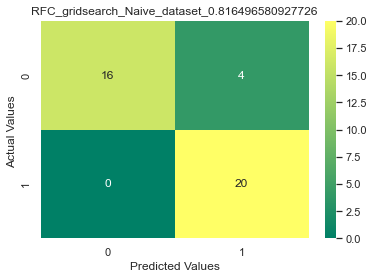

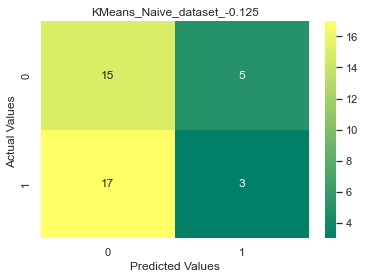

In [103]:
clf = classifiers.get('ADABoost')
y_predict1 = clf.predict(naive_dataset)
scoring = matthews_corrcoef(naive_y, y_predict1)
scores.append(scoring)     
cf_matrix1 = confusion_matrix(naive_y, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("ADABoost_Naive_dataset_"+str(scoring))
ax1.set_title(title);
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

naive_labels = naive_labels1+naive_labels2
naive_y=naive_labels
clf = rf_grid_search
y_predict1 = clf.predict(naive_dataset)
scoring = matthews_corrcoef(naive_y, y_predict1)
scores.append(scoring)     
cf_matrix1 = confusion_matrix(naive_y, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("RFC_gridsearch_Naive_dataset_"+str(scoring))
ax1.set_title(title);
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

naive_labels = naive_labels1+naive_labels2
naive_y=naive_labels
clf = classifiers.get('KMeans')
y_predict1 = clf.predict(naive_dataset)
scoring = matthews_corrcoef(naive_y, y_predict1)
scores.append(scoring)     
cf_matrix1 = confusion_matrix(naive_y, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("KMeans_Naive_dataset_"+str(scoring))
ax1.set_title(title);
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

It seems even GridSearchCV has not improved the RFC to the extent of the ADABoost, but it still shows good overall performance! As expected, we don't see very good performance with KMeans as it has mostly thought that all antibodies fit in Class 0 (Human).

## Dimensionality Reduction

As an extra task, we may try dimensionality reduction to see if that improves the performance of poorer predictors. Principal Component Analysis (PCA) is commonly applied in machine learning as a pre-processing step when dealing with data that has many data points per sample. This increases interpretability of our data and also allows us to plot it visually. In short it works to find data points that can be grouped together and represented in a vector (principal components) to explain the variability seen in the data. Usually they are ordered in reverse of how much variability they can explain (e.g. PC1 would explain variability the most, PCn would explain the least variability). 

We will apply PCA on our dataset and see if this changes the performance of our predictors.

In [72]:
nComp = 50 # Number of PCs to be returned
#trainIndx = np.random.binomial(1,0.9,size=filectr)

threshold = 0.999999


EncodingPCA = PCA(n_components=nComp, whiten=True)
EncodingPCA = EncodingPCA.fit(dataset)

cumExpVar = np.cumsum(EncodingPCA.explained_variance_ratio_)
keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]

NewEncodingPCA = EncodingPCA.transform(dataset)[:,range(keepPC)]
print(NewEncodingPCA.shape)



(2000, 25)


In [73]:

X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(NewEncodingPCA, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


In [96]:
scores_PCA = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train_PCA,y_train_PCA)
    y_predict1 = clf_1.predict(X_test_PCA)
    scoring = matthews_corrcoef(y_test_PCA, y_predict1)
    scores_PCA.append(scoring)
    plt.show()


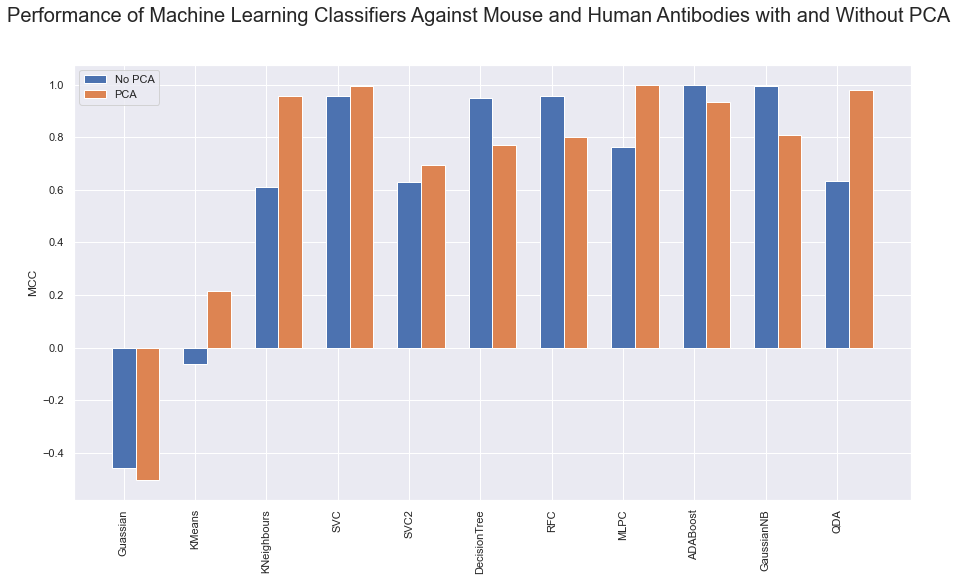

In [95]:
import numpy as np 
import matplotlib.pyplot as plt 
labels = list(classifiers.keys())
aranged = np.arange(len(classifiers)) 
width = 1/3

fig, ax = plt.subplots(figsize=(15,8))

bar1 = plt.bar(aranged, scores, width,label = 'No PCA')
bar2 = plt.bar(aranged+width, scores_PCA , width,label = 'PCA')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without PCA', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We see that some classifiers improve performance (SVC, MLPC,QDA) with the PCA but this is not always the case (Decision Tree, RFC, ADABoost). 

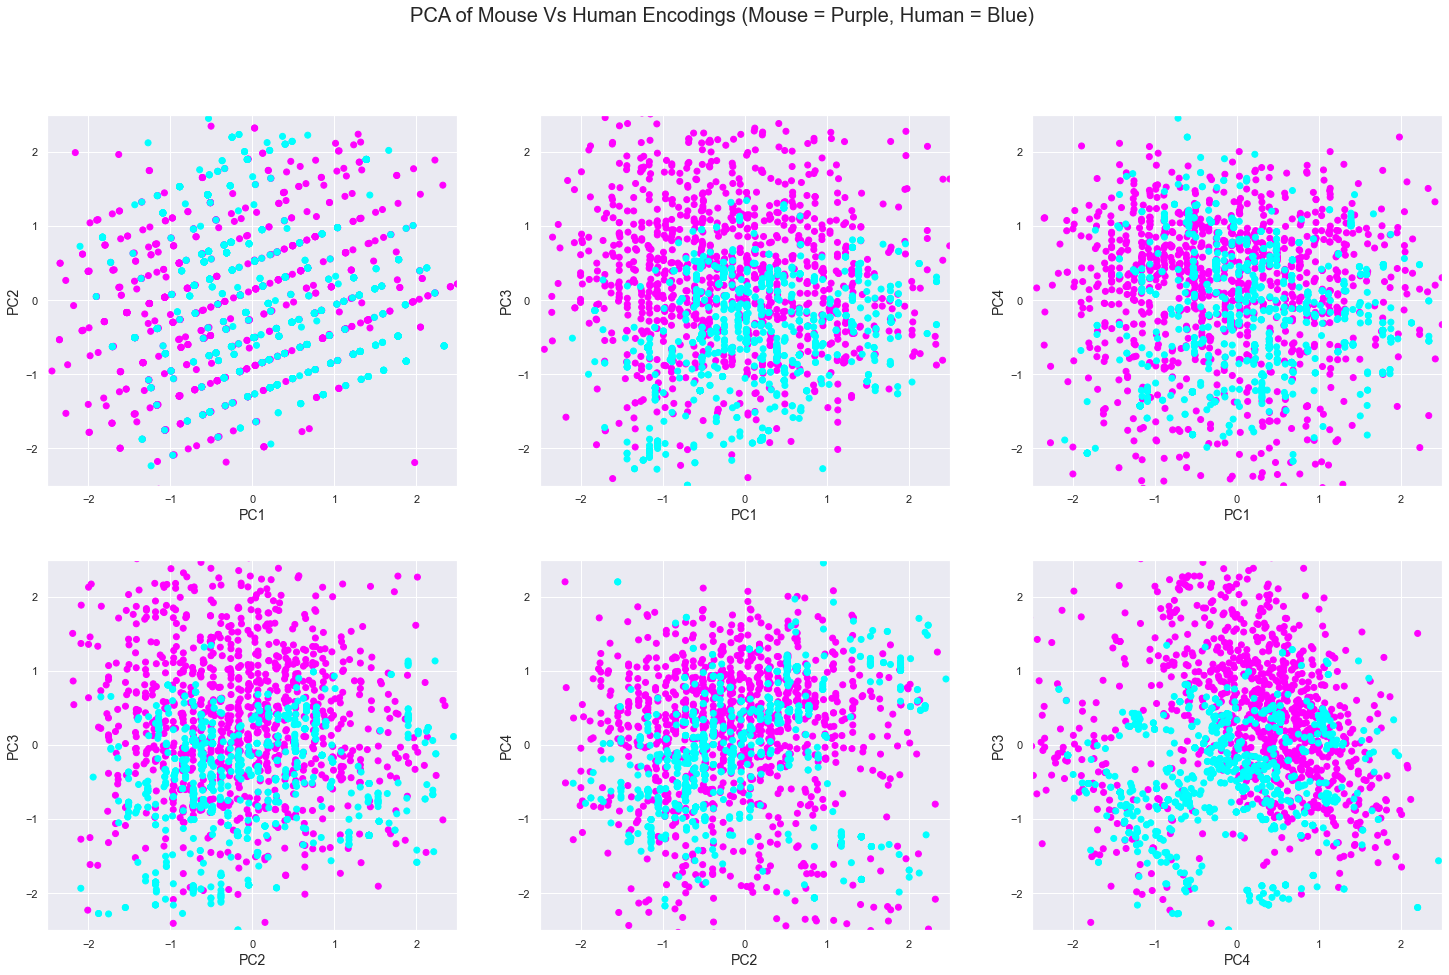

In [65]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))
plt.suptitle('PCA of Mouse Vs Human Encodings (Mouse = Purple, Human = Blue)', fontsize=20)

ax[0, 0].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,1], c=y, cmap='cool');
ax[0, 0].set_xlabel('PC1', fontsize=14); ax[0, 0].set_xlim([-2.5,2.5]);
ax[0, 0].set_ylabel('PC2', fontsize=14); ax[0, 0].set_ylim([-2.5,2.5]);


ax[0, 1].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[0, 1].set_xlabel('PC1', fontsize=14); ax[0, 1].set_xlim([-2.5,2.5]);
ax[0, 1].set_ylabel('PC3', fontsize=14); ax[0, 1].set_ylim([-2.5,2.5]);


ax[0, 2].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[0, 2].set_xlabel('PC1', fontsize=14); ax[0, 2].set_xlim([-2.5,2.5]);
ax[0, 2].set_ylabel('PC4', fontsize=14); ax[0, 2].set_ylim([-2.5,2.5]);


ax[1, 0].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 0].set_xlabel('PC2', fontsize=14); ax[1, 0].set_xlim([-2.5,2.5]);
ax[1, 0].set_ylabel('PC3', fontsize=14); ax[1, 0].set_ylim([-2.5,2.5]);


ax[1, 1].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[1, 1].set_xlabel('PC2', fontsize=14); ax[1, 1].set_xlim([-2.5,2.5]);
ax[1, 1].set_ylabel('PC4', fontsize=14); ax[1, 1].set_ylim([-2.5,2.5]);


ax[1, 2].scatter(NewEncodingPCA[:,3], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 2].set_xlabel('PC4', fontsize=14); ax[1, 2].set_xlim([-2.5,2.5]);
ax[1, 2].set_ylabel('PC3', fontsize=14); ax[1, 2].set_ylim([-2.5,2.5]);




We can see here that the graphs showing PC1 against PC3 and PC2 against PC3 show some the best separation between human and mouse antibodies. We can use this to support the trustworthiness of our dimensionality reduction technique.

## Do it yourself

We can use other methods of reducing the dimensionality of the dataset. F-regression is a technique that selects the n most relevant features to the target variable. It can be performed on the dataset like so:

>from sklearn.feature_selection import SelectKBest

>from sklearn.feature_selection import f_regression

>n = 100

>X_NUMPY, Y_NUMPY = X.to_numpy(),y.to_numpy()

>fs = SelectKBest(score_func=f_regression, k=n)

>X_selected = fs.fit_transform(X_NUMPY, Y_NUMPY)


- Experiment with the n this method of dimensionality reduction on your data and see how the results compare to the Principle Component Analysis

## Using Deep Learning to Classify Human and Mouse Antibodies

Finally, we can try using deep learning by constructing our own artificial neural network using Keras. This is a different tehcnique to the machine learning we have seen above as these networks are sophisticated algorithms built by the computer and trained to best perform on the data. 
Below is a very simple model with three layers, and compiled to act as a binary classifier for our dataset.

In [82]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [ ]:
#Initialising ANN
import tensorflow as tf

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)
X_test_np =  np.asarray(X_test)
y_test_np =  np.asarray(y_test)
print(X_train.shape)

ann = tf.keras.models.Sequential([tf.keras.layers.Dense(32, input_shape=(X_train.shape[1],)),
                                (tf.keras.layers.Dense(20,activation="relu")),
                                (tf.keras.layers.Dense(1,activation="sigmoid"))])

ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=[tf.keras.metrics.BinaryAccuracy()])
#Fitting ANN
history = ann.fit(X_train_np,y_train_np,epochs = 20, validation_data =(X_test_np,y_test_np), verbose = 0)
performance = ann.evaluate(X_test_np, y_test_np)


(1400, 890)
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in 

In [81]:
predict = ann.predict(X_test_np)
predict_binary = []
for x in predict:
    if x[0] > 0.5:
        predict_binary.append(1)
    elif x[0] < 0.5:
        predict_binary.append(0)
performance = ann.evaluate(X_test_np, y_test_np)
#print(performance)
MCC = matthews_corrcoef(y_test,predict_binary)
print(MCC)

19/19 [==============================] - 0s 1ms/step - loss: 0.3224 - binary_accuracy: 0.9667
0.9346835140049147


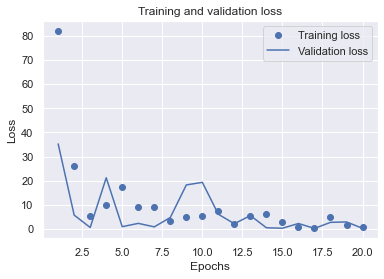

In [84]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

End of Chapter Exercise

>We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings. What if we want to separate more species? Included in this worksheet is a dataset of 1000 rat antibodies as well as the previously used 1000 human and 1000 mouse antibodies. Try generating additional classifieres to separate additional combinations of species (i.e. human Vs rat and mouse Vs rat). Use any of the hyperparameterisation techniques you see fit. 

>> Report which of these classifiers was the easiest to build.

>> Think of reasons why some of these classifiers may be difficult to build

Keypoints

> Protein sequences must be numerically encoded to be readable by machine learning algorithms.

> It is sometimes necessary to experiment with different machine learning classifiers or hyperparameterisation techniques to achieve the best prediction results.

> Check the performance of your model with a "held back" dataset which was not included in the training or testing sets.

 